# DiploDatos Kaggle Competition
### Grupo 23

**Integrantes:** Franco Amilcar Genolet (francogeno97@gmail.com), Fabian Alejandro Zapata Cerutti (fzc501@gmail.com), Luis Alejandro Guedez Gomez (luis.guedez@dicsys.com), María Laura Mantovani (mantovanimlaura@gmail.com).

### Librerías

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_score, accuracy_score, recall_score

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore") 

### Importación del dataset

In [14]:
df = pd.read_csv("https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/train.csv")

### Exporación y análisis de los datos

In [15]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1
2,8430,Europa,True,B/343/S,TRAPPIST-1e,33.0,NaN,0.0,0.0,0.0,0.0,0.0,Shaiam Tinganking,1
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,Landa Grifford,0
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey,0


In [16]:
df.shape

(7823, 14)

Se tiene un dataset con 7.823 registros, 13 variables explicativas y una variable Target (Transported). La descripción de las variables (fuente: [kaggle.com](https://www.kaggle.com/competitions/spaceship-titanic/overview)) es la siguiente:

* PassengerId: Id único por pasajero. 
* HomePlanet: Planeta del cual el pasajero parte, típicamente su planeta de residencia permanente.
* CryoSleep: Indica si el pasajero eligió ser puesto en animación suspendida durante la duración del viaje. Los pasajeros en criosueño están confinados en sus cabinas.
* Cabin: El número de cabina en donde se queda el pasajero. Toma la forma cubierta/número/lado, donde lado puede ser P para babor o S para estribor.
* Destination: El planeta al que desembarcará el pasajero.
* Age: La edad del pasajero.
* VIP: Indica si el pasajero pagó por servicio especial VIP durante el viaje.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: Monto que el pasajero ha facturado en cada uno de los servicios de lujo del Spaceship Titanic.
* Name: Nombre y apellido del pasajero.
* Transported: Indica si el pasajero fue transportado a otra dimensión. Este es el target, la columna que está tratando de predecir.

Veamos ahora cuántos nulos, ceros y valores únicos existen por cada variable, y qué tipo de dato es cada una.

In [17]:
def status(data):
    data2=data
    # total de rows
    tot_rows=len(data2)
    # total de nan
    d2=data2.isnull().sum().reset_index()
    d2.columns=['variable', 'q_nan']
    # percentage of nan
    d2[['p_nan']]=d2[['q_nan']]/tot_rows
    # num of zeros
    d2['q_zeros']=(data2==0).sum().values
    # perc of zeros
    d2['p_zeros']=d2[['q_zeros']]/tot_rows
    # total unique values
    d2['unique']=data2.nunique().values
    # get data types per column
    d2['type']=[str(x) for x in data2.dtypes.values]
    return(d2)
status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.000000,1,0.000128,7823,int64
1,HomePlanet,179,0.022881,0,0.000000,3,object
2,CryoSleep,196,0.025054,4871,0.622651,2,object
3,Cabin,184,0.023520,0,0.000000,6009,object
4,Destination,160,0.020453,0,0.000000,3,object
5,Age,162,0.020708,160,0.020453,80,float64
6,VIP,184,0.023520,7456,0.953087,2,object
7,RoomService,154,0.019686,5042,0.644510,1195,float64
8,FoodCourt,155,0.019813,4940,0.631471,1400,float64
9,ShoppingMall,188,0.024032,5036,0.643743,1045,float64


PassengerId y Transported son las únicas variables que no tienen faltantes. Veamos cómo se comportan estos faltantes en las otras variables para decidir qué hacer con ellos:

<AxesSubplot:>

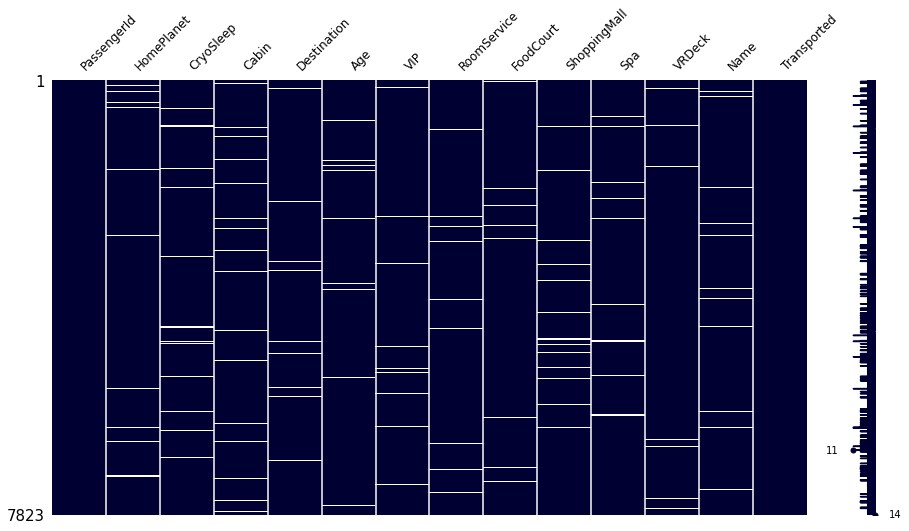

In [18]:
msno.matrix(df,figsize=(15, 8), fontsize=12, color=[0,0,0.2])


Vemos que los datos faltantes son aleatorios y no parecen responder a un problema sistemático. Haremos un análisis exploratorio de las variables antes de comenzar.

Graficamos las variables numéricas con respecto a la variable target:

In [19]:
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

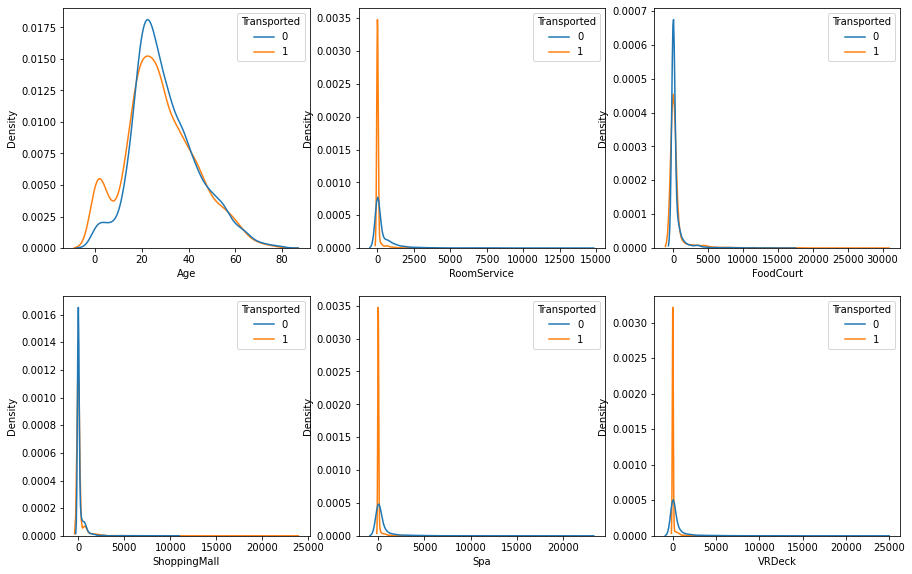

In [20]:
fig = plt.figure(figsize=(15, 15))

for i, coln in enumerate(numerical_cols):
    ax = fig.add_subplot(3,3,i+1)
    sns.kdeplot(data=df, x=coln, hue='Transported')

En cuanto a la edad, se observa que la distribución de los pasajeros transportados se encuentra algo más corrida hacia la izquierda, lo cual podría indicar un grupo más joven. Hay un pequeño salto en la densidad de este grupo cuando los valores son menores 10 aproximadamente. En cuanto a RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (monto facturado en servicios de lujo), las distribuciones estan fuertemente concentradas en el cero. Esto es por el volumen de pasajeros que no facturaron esos servicios. 

Analicemos ahora el boxplot de estas variables en cada grupo para comparar los cuartiles de las respectivas distribuciones:

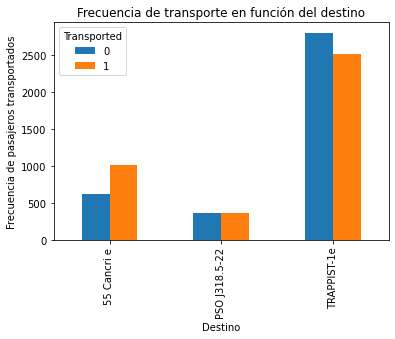

In [21]:
plt.figure(figsize = (10,10))
%matplotlib inline
pd.crosstab(df.Destination, df.Transported).plot(kind="bar")
plt.title("Frecuencia de transporte en función del destino")
plt.xlabel("Destino")
plt.ylabel("Frecuencia de pasajeros transportados")
plt.show()

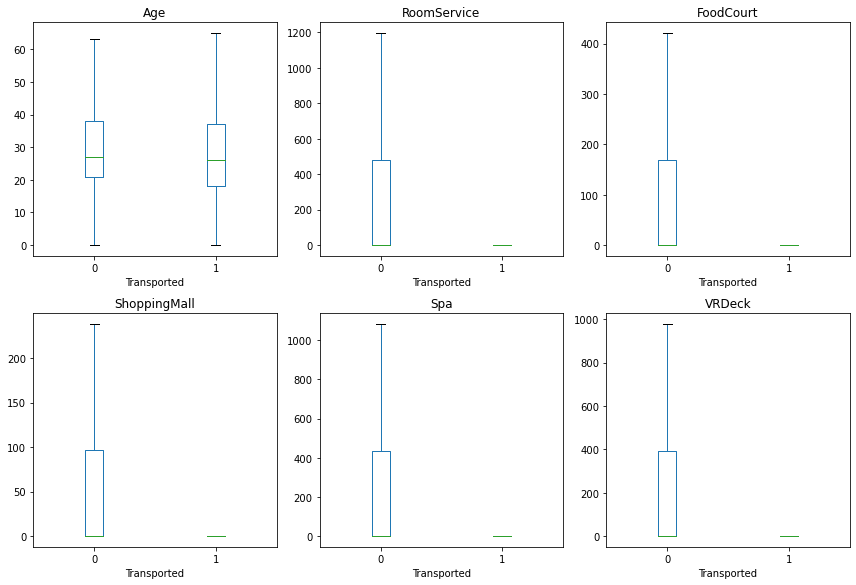

In [22]:
fig = plt.figure(figsize=(12, 12))

for i, coln in enumerate(numerical_cols):
    ax = fig.add_subplot(3,3,i+1)
    df.boxplot(coln, ax=ax, by='Transported',grid=False,showfliers=False);  

fig.suptitle('')
plt.tight_layout()

Como se puede ver en el boxplot, las variables RoomService, FoodCourt, ShoppingMall, Spa, VRDeck (monto facturado en servicios de lujo), tienen mediana cero tanto para el grupo de transportados como para el grupo de no transportados. Sin embargo el grupo de no transportados tiene más datos por encima de esa mediana. A continuación vemos este mismo gráfico pero sin quitar los fliers (valores que se encuentran por fuera de 1.5 por el rango intercuartílico, y podrían considerarse outliers):

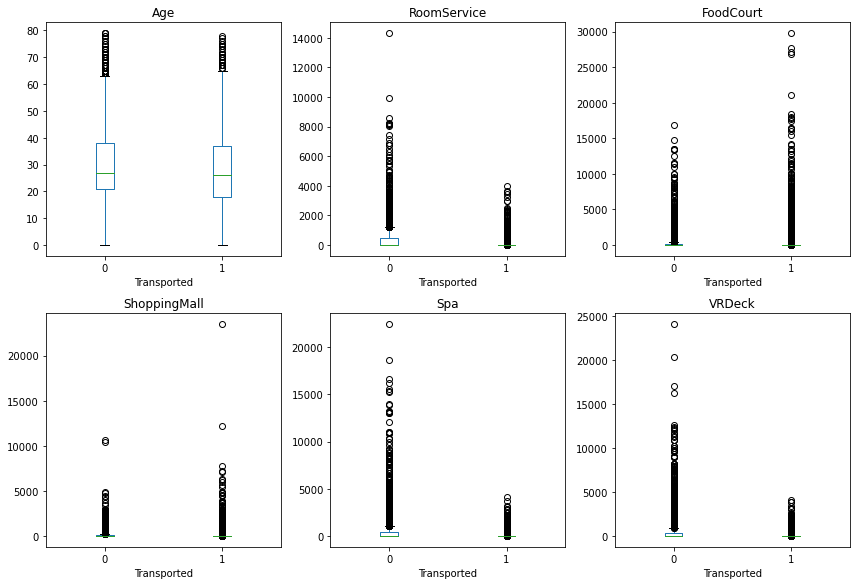

In [23]:
fig = plt.figure(figsize=(12, 12))

for i, coln in enumerate(numerical_cols):
    ax = fig.add_subplot(3,3,i+1)
    df.boxplot(coln, ax=ax, by='Transported',grid=False,showfliers=True);  

fig.suptitle('')
plt.tight_layout()

A continuación se grafican las variables categóricas. Separamos Cabin en 3 para ver también cómo se comportan con respecto a la variable target.

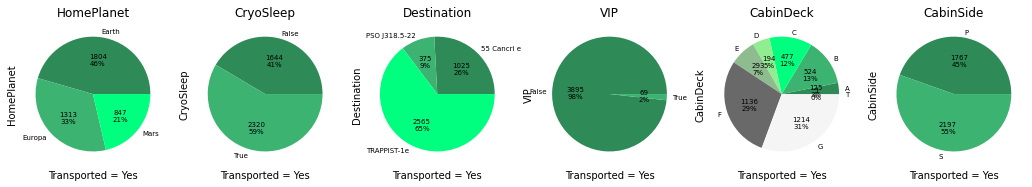

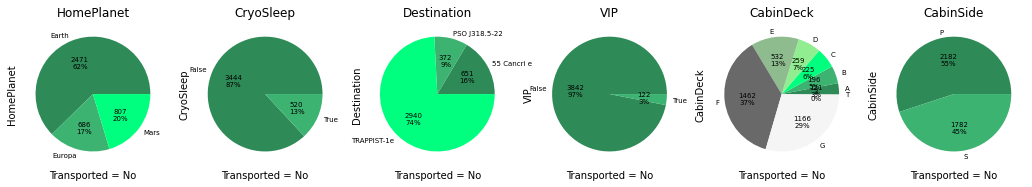

In [27]:
fig1 = plt.figure(figsize=(18, 18))
for i, coln in enumerate(categorical_cols):
    ax1 = fig1.add_subplot(1,len(categorical_cols),i+1)
    ax1.set_title(categorical_cols[i])
    tr_yes.groupby(categorical_cols[i]).size().plot(kind='pie', autopct=labeling_yes, textprops={'fontsize': 7},colors=colors, ax=ax1)
    ax1.set_xlabel('Transported = Yes', size=10)
    ax1.set_ylabel(categorical_cols[i], size=10)

plt.show()
fig2 = plt.figure(figsize=(18, 18))
for i, coln in enumerate(categorical_cols):
    ax2 = fig2.add_subplot(1,len(categorical_cols),i+1)
    ax2.set_title(categorical_cols[i])
    tr_no.groupby(categorical_cols[i]).size().plot(kind='pie', autopct=labeling_yes, textprops={'fontsize': 7},colors=colors, ax=ax2)
    ax2.set_xlabel('Transported = No', size=10)
    ax2.set_ylabel(categorical_cols[i], size=10)

plt.show()

En principio, las variables que en mayor medida muestran distribuciones diferenciadas entre las clases son: CryoSleep y HomePlanet (Europa y Tierra). También puede que Cabin_Side este teniendo alguna influencia. Se codifican también Destination y VIP para terminar de evaluar si serán descartadas o no más adelante.

In [29]:
fill_values = {'CryoSleep': 0, 'Cabin': 0, 'Age': np.mean(df['Age']), 'VIP': 0, 
              'RoomService': np.mean(df['RoomService']), 'FoodCourt': np.mean(df['FoodCourt']), 
               'ShoppingMall': np.mean(df['ShoppingMall']), 'Spa': np.mean(df['Spa']),
               'VRDeck': np.mean(df['VRDeck']), "Name": 0  
              }

In [32]:
data_copy = df.copy()

In [33]:
data_copy.describe()

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinNum
count,7823.000000,7661.000000,7669.000000,7668.000000,7635.000000,7665.000000,7654.000000,7823.000000,7639.000000
mean,4345.691039,28.879389,226.078237,455.643062,172.600393,305.023222,295.476744,0.506711,598.233931
std,2504.576803,14.461548,679.180148,1621.290107,597.923749,1133.423579,1093.485752,0.499987,511.402123
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2182.500000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000
50%,4345.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,424.000000
75%,6515.500000,38.000000,44.000000,69.000000,28.000000,58.000000,46.000000,1.000000,992.000000
max,8692.000000,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,1893.000000


### Imputar los NaNs
* Home Planet: por la pequeña cant que son y por su complicada imputacion, se eliminaran
* Destination: DropNa

In [53]:
data_copy = data_copy.fillna(value=fill_values)
data_copy = data_copy.dropna()

In [66]:
data_copy.replace(True, 1, inplace= True)
data_copy.replace(False, 0, inplace= True)

In [67]:
print(data_copy.shape)
status(data_copy)

(7312, 17)


,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.0,1,0.000137,7312,int64
1,HomePlanet,0,0.0,0,0.000000,3,object
2,CryoSleep,0,0.0,4741,0.648386,2,int64
3,Cabin,0,0.0,0,0.000000,5776,object
4,Destination,0,0.0,0,0.000000,3,object
5,Age,0,0.0,152,0.020788,81,float64
6,VIP,0,0.0,7141,0.976614,2,int64
7,RoomService,0,0.0,4712,0.644420,1147,float64
8,FoodCourt,0,0.0,4621,0.631975,1350,float64
9,ShoppingMall,0,0.0,4694,0.641958,1015,float64


In [68]:
for i in data_copy:
    if data_copy[i].dtype == "object":
        print("Los valores unicos de la variable {} son:\n{}".format(i, data_copy[i].unique()))

Los valores unicos de la variable HomePlanet son:
['Europa' 'Earth' 'Mars']
Los valores unicos de la variable Cabin son:
['C/123/P' 'B/343/S' 'F/1420/P' ... 'G/459/S' 'F/1772/P' 'E/253/P']
Los valores unicos de la variable Destination son:
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']
Los valores unicos de la variable Name son:
['Azhah Tronsive' 'Shaiam Tinganking' 'Landa Grifford' ... 'Panzel Ruity'
 'Belly Weavesend' 'Graston Donotaked']
Los valores unicos de la variable CabinDeck son:
['C' 'B' 'F' 'G' 'E' 'D' 'A' 'T']
Los valores unicos de la variable CabinSide son:
['P' 'S']


In [69]:
print(pd.crosstab(data_copy.CryoSleep, data_copy.Transported))

Transported     0     1
CryoSleep              
0            3139  1602
1             470  2101


En principio, hay una relacion entre el pasajero transportado y si la decision fue hacer el viaje en realidad suspendida. Es decir, si el pasajero escogio el "Cryo Sleep" es mas probable que lo transporten. 

In [221]:
features = df.columns.values.tolist()

In [233]:
X  = data_copy[(f for f in features if f not in ['Transported', 'Name', 'Cabin'])]
y = data_copy.Transported

In [234]:
print(X.shape)
status(X)

(7312, 14)


,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.0,1,0.000137,7312,int64
1,HomePlanet,0,0.0,0,0.000000,3,object
2,CryoSleep,0,0.0,4741,0.648386,2,int64
3,Destination,0,0.0,0,0.000000,3,object
4,Age,0,0.0,152,0.020788,81,float64
5,VIP,0,0.0,7141,0.976614,2,int64
6,RoomService,0,0.0,4712,0.644420,1147,float64
7,FoodCourt,0,0.0,4621,0.631975,1350,float64
8,ShoppingMall,0,0.0,4694,0.641958,1015,float64
9,Spa,0,0.0,4495,0.614743,1193,float64


#### One - Hot Encoding para variables categoricas

In [235]:
objectFeatures = ["Destination", "HomePlanet", "CabinDeck", "CabinSide"]

In [236]:
from sklearn.preprocessing import OneHotEncoder

In [237]:
enc = OneHotEncoder()
toAppend = enc.fit_transform(x[objectFeatures]).toarray()
featureLabels = np.array(enc.categories_).ravel()
print(featureLabels.shape)

(4,)


In [238]:
featureCols = []
for f in featureLabels:
    for i in f:
        featureCols.append(i)
featureCols

['55 Cancri e',
 'PSO J318.5-22',
 'TRAPPIST-1e',
 'Earth',
 'Europa',
 'Mars',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'T',
 'P',
 'S']

In [239]:
df_encoded = pd.DataFrame(toAppend, columns=featureCols)
df_encoded.head()

,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,Earth,Europa,Mars,A,B,C,D,E,F,G,T,P,S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [240]:
print(df_encoded.shape, X.shape)

(7312, 16) (7312, 14)


In [241]:
X = X.reset_index(drop = True)

In [242]:
print(df_encoded.shape, X.shape)

(7312, 16) (7312, 14)


In [243]:
X = pd.concat([X, df_encoded], axis=1)
X.shape

(7312, 30)

In [244]:
X.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'CabinDeck', 'CabinNum', 'CabinSide', '55 Cancri e', 'PSO J318.5-22',
       'TRAPPIST-1e', 'Earth', 'Europa', 'Mars', 'A', 'B', 'C', 'D', 'E', 'F',
       'G', 'T', 'P', 'S'],
      dtype='object')

In [245]:
X = X.drop(objectFeatures, axis = 1)

In [247]:
X.shape

(7312, 26)

In [248]:
status(X)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,PassengerId,0,0.0,1,0.000137,7312,int64
1,CryoSleep,0,0.0,4741,0.648386,2,int64
2,Age,0,0.0,152,0.020788,81,float64
3,VIP,0,0.0,7141,0.976614,2,int64
4,RoomService,0,0.0,4712,0.644420,1147,float64
5,FoodCourt,0,0.0,4621,0.631975,1350,float64
6,ShoppingMall,0,0.0,4694,0.641958,1015,float64
7,Spa,0,0.0,4495,0.614743,1193,float64
8,VRDeck,0,0.0,4613,0.630881,1181,float64
9,CabinNum,0,0.0,15,0.002051,1753,float64


Text(0.5, 1.0, 'Correlation between Variables')

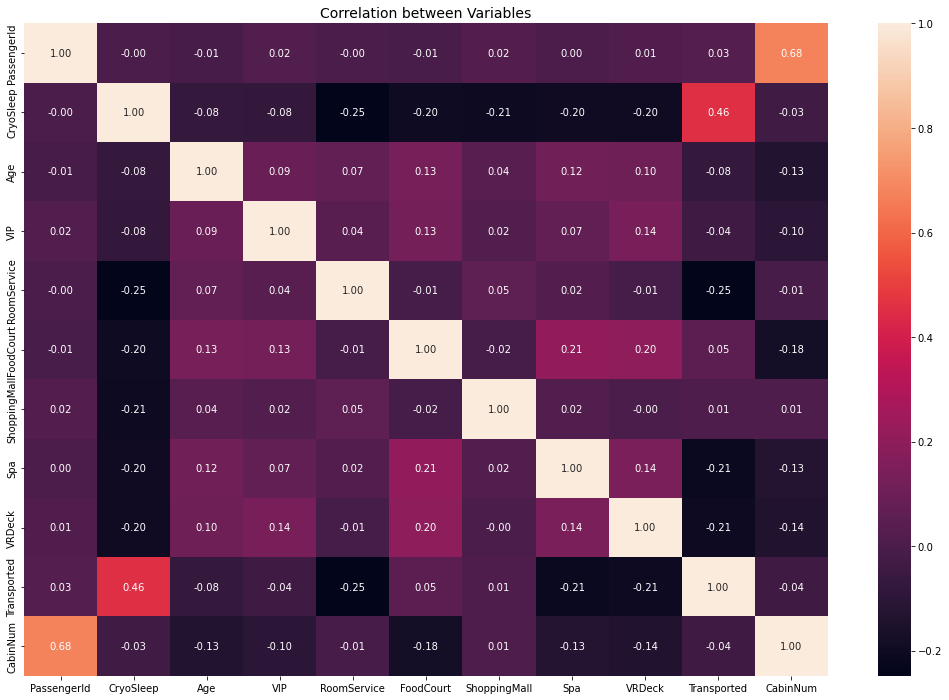

In [249]:
# Revisamos que no haya una correlación fuerte entre nuestras variables explicativas
plt.figure(figsize=(18,12))
sns.heatmap(data_copy.corr(),annot=True, fmt='.2f')
plt.title('Correlation between Variables', fontsize=14)

In [250]:
# Escalamos
x_names = X.columns
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
X_orig = X.copy(deep=True)
X = scaler.fit_transform(X_orig)
X = pd.DataFrame(X, columns=x_names)
X

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNum,...,A,B,C,D,E,F,G,T,P,S
0,0.394616,0.0,0.721519,0.0,0.000000,0.129440,0.000553,0.008702,0.160527,0.064976,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.969857,1.0,0.417722,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.181194,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.743557,0.0,0.544304,0.0,0.014315,0.040519,0.000000,0.000000,0.008453,0.750132,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.009779,0.0,0.240506,0.0,0.000000,0.000000,0.028520,0.000045,0.001409,0.004754,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.872757,0.0,0.291139,0.0,0.009073,0.000134,0.000000,0.000312,0.024365,0.820391,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7307,0.751035,0.0,0.151899,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.696778,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7308,0.309825,0.0,0.556962,0.0,0.000000,0.000000,0.031670,0.002767,0.000124,0.242472,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7309,0.929130,1.0,0.696203,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.936080,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7310,0.440520,0.0,0.189873,0.0,0.000000,0.028176,0.005236,0.000000,0.000829,0.133650,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Entrenamiento y Test

In [251]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

In [252]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5849, 26), (5849,), (1463, 26), (1463,))

### Modelo Baseline

In [253]:
clfs = [DecisionTreeClassifier()]
names = ['Árbol de decisión']

trained_models = []
accuracy_models = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train, y_train)
    train_predictions = clf.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    train_predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, train_predictions)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models.append(clf)
    accuracy_models.append(accuracy*100)

Árbol de decisión
Accuracy train Árbol de decisión: 100.00%
Accuracy test {name}: 74.71%


### Algún tipo de ajuste de hiperparámetros de los modelos elegidos

In [254]:
grid = GridSearchCV(DecisionTreeClassifier(),
 {'criterion':('gini','entropy'),
 'splitter':("best","random"),
 'max_depth':(10,20,100)})
grid.fit(x_train,y_train)
grid.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'splitter': 'best'}

In [255]:
clf = DecisionTreeClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions = clf.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test,clf.predict(x_test)))

Accuracy train Arbol de decisión: 84.44%
Accuracy test Arbol de decisión: 76.83%
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       717
           1       0.78      0.76      0.77       746

    accuracy                           0.77      1463
   macro avg       0.77      0.77      0.77      1463
weighted avg       0.77      0.77      0.77      1463



In [256]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train)
y_train2 = np.array(y_train)


for clfi, name in zip([DecisionTreeClassifier(**grid.best_params_)],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

DecisionTreeClassifier(criterion='entropy', max_depth=10)
Precisión test fold 0: 77.35
Precisión test fold 1: 77.01
Precisión test fold 2: 77.52
Precisión test fold 3: 76.67
Precisión test fold 4: 76.13
Avg. accuracy = 76.93609118758819


### Validamos ahora varios modelos para obtener mayor Accuracy

### Primero validaremos con varios modelos para verificar cual puede ser que obtenga un mayor Accuracy

In [257]:
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, roc_auc_score, mean_squared_error, r2_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

clfs =  [DecisionTreeClassifier(),
        RandomForestClassifier(),
        LogisticRegression(),
        MLPClassifier(),
        XGBClassifier(),
        GaussianNB(),
        LinearSVC()]

names = ['Arbol de decisión',
        'Random Forest',
        'Regresión Logística',
        'Perceptrón multicapa',
        'XGBoost',
        'Naive Bayes',
        'SVM']

trained_models = []
accuracy_models = []
for clf, name in zip(clfs, names):
    print(name)
    clf.fit(x_train, y_train)
    
    train_predictions = clf.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    test_predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    trained_models.append(clf)    
    accuracy_models.append(accuracy)

Arbol de decisión
Accuracy train Arbol de decisión: 100.00%
Accuracy test Arbol de decisión: 74.30%
Random Forest
Accuracy train Random Forest: 100.00%
Accuracy test Random Forest: 79.56%
Regresión Logística
Accuracy train Regresión Logística: 76.63%
Accuracy test Regresión Logística: 77.51%
Perceptrón multicapa
Accuracy train Perceptrón multicapa: 83.06%
Accuracy test Perceptrón multicapa: 80.25%
XGBoost
Accuracy train XGBoost: 94.89%
Accuracy test XGBoost: 79.70%
Naive Bayes
Accuracy train Naive Bayes: 73.36%
Accuracy test Naive Bayes: 74.64%
SVM
Accuracy train SVM: 78.71%
Accuracy test SVM: 78.33%


In [258]:
models = pd.DataFrame({'Model':names, 'Score':accuracy_models})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Perceptrón multicapa,0.802461
4,XGBoost,0.796992
1,Random Forest,0.795625
6,SVM,0.783322
2,Regresión Logística,0.775120
5,Naive Bayes,0.746411
0,Arbol de decisión,0.742994


#### En esta validacion de por todos los modelos, se puede observar que el que mejor comportamiento se obtuvo fue el de XGBoost, ya que obtiene un balance entre el tran y el test

#### Ahora validaremos cuales serian los mejores parametros para el modelo de XGBoost.

In [259]:
from xgboost import XGBClassifier

params={
 "learning_rate"    : [0.05, 0.10, 0.1] ,
 "max_depth"        : [ 3, 4, 5],
 "min_child_weight" : [ 1, 3, 5],
 "gamma"            : [ 0.0, 0.1, 0.2]   
}


In [260]:
classifier=XGBClassifier()

In [261]:
grid = GridSearchCV(classifier,params)

In [262]:
grid.fit(x_train,y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_...None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.1],
                         'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 3, 5]})

In [263]:
grid.best_params_

{'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3}

In [264]:
clfxboost = XGBClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions = clfxboost.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clfxboost.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
plt.show()

Accuracy train Arbol de decisión: 84.31%
Accuracy test Arbol de decisión: 80.31%


In [265]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       717
           1       0.82      0.79      0.80       746

    accuracy                           0.80      1463
   macro avg       0.80      0.80      0.80      1463
weighted avg       0.80      0.80      0.80      1463



              precision    recall  f1-score   support

           0       0.79      0.82      0.80       717
           1       0.82      0.79      0.80       746

    accuracy                           0.80      1463
   macro avg       0.80      0.80      0.80      1463
weighted avg       0.80      0.80      0.80      1463



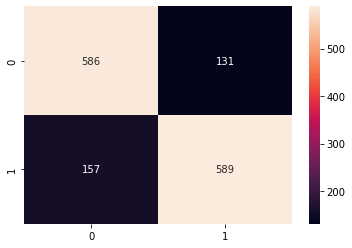

In [266]:
print(classification_report(y_test, test_predictions))
from sklearn.metrics import confusion_matrix,roc_curve

cm = confusion_matrix(y_test, test_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

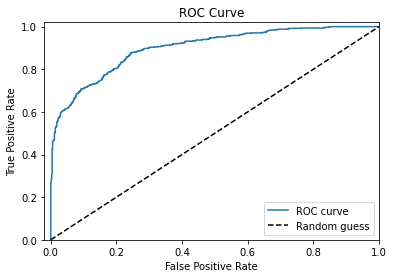

In [267]:
fpr, tpr, thresholds = roc_curve(y_test,clfxboost.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")

In [268]:
roc_auc_score(y_test, test_predictions)

0.8034192588271807

#### Debido a que el GridsearchCV para este este modelo se tarda, validaremos tambien por RandomSearchCV para verificar si se obtienen mejores o mismos resultados

In [269]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(classifier,param_distributions=params,n_iter=30,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'gamma': [0.0, 0.1, 0.2],
                                        'learning_rate': [0.05, 0.1, 0.1],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 3, 5]},
                   scoring='roc_auc', verbose=3)

In [270]:
random_search.best_params_

{'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.0}

In [271]:
clfrandom_search = XGBClassifier(**random_search.best_params_).fit(x_train, y_train)

train_predictions = clfrandom_search.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clfrandom_search.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
plt.show()


Accuracy train Arbol de decisión: 84.31%
Accuracy test Arbol de decisión: 80.31%


In [272]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       717
           1       0.82      0.79      0.80       746

    accuracy                           0.80      1463
   macro avg       0.80      0.80      0.80      1463
weighted avg       0.80      0.80      0.80      1463



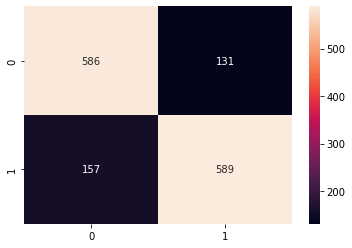

In [273]:
from sklearn.metrics import confusion_matrix,roc_curve

cm = confusion_matrix(y_test, test_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

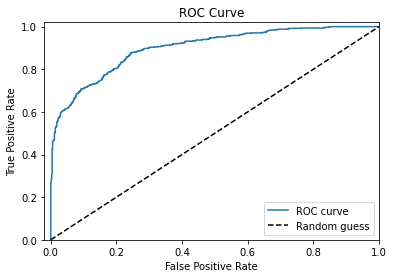

In [274]:
fpr, tpr, thresholds = roc_curve(y_test,clfrandom_search.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")

In [275]:
roc_auc_score(y_test, test_predictions)

0.8034192588271807

#### Por lo analizado anteriormente, los mejores parametros se obtuvieron con el GridsearchCV aun cuando su procesamiento sea tardio, ahora validaremos un modelo diferente para verificar si se consigo una payor precision.

In [276]:
param_grid = {
             'max_depth'   : [3, 10, 20],
             'min_samples_leaf': [0.05, 0.1],
             'max_features': ['sqrt', 'log2'],
             'ccp_alpha': [0, 0.01]
            }

model = RandomForestClassifier(
            n_estimators = 100,
            oob_score    = True,
            n_jobs       = -1,
            random_state = 123
        )
grid = GridSearchCV(
        estimator  = model,
        param_grid = param_grid,
        scoring    = 'roc_auc',
        cv         = 5, 
        refit      = False,
        verbose    = 0,
        return_train_score = True
       )

In [277]:
grid.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=123),
             param_grid={'ccp_alpha': [0, 0.01], 'max_depth': [3, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [0.05, 0.1]},
             refit=False, return_train_score=True, scoring='roc_auc')

In [278]:
grid.best_params_

{'ccp_alpha': 0,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.05}

In [279]:
clfrandomForest = RandomForestClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions = clfrandomForest.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clfrandomForest.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
plt.show()

Accuracy train Arbol de decisión: 74.39%
Accuracy test Arbol de decisión: 75.19%


In [280]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77       717
           1       0.82      0.66      0.73       746

    accuracy                           0.75      1463
   macro avg       0.76      0.75      0.75      1463
weighted avg       0.76      0.75      0.75      1463



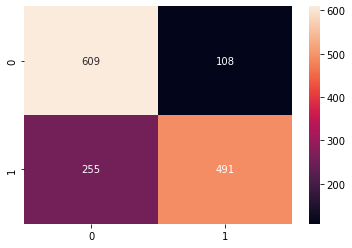

In [281]:
from sklearn.metrics import confusion_matrix,roc_curve

cm = confusion_matrix(y_test, test_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

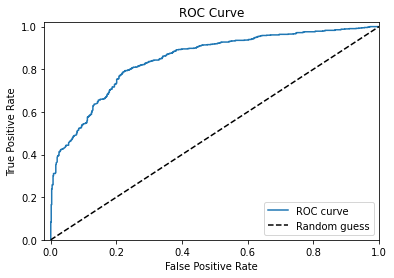

In [282]:
fpr, tpr, thresholds = roc_curve(y_test,clfrandomForest.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")

In [283]:
roc_auc_score(y_test, test_predictions)

0.7537746643184852

## En conclusion, el mejor modelo es el XGBClassifier con los parametros: 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3

## Generar la salida para entregar

In [284]:
test_df = pd.read_csv('Práctico_Aprendizaje_supervisado/test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Práctico_Aprendizaje_supervisado/test.csv'

In [ ]:
test_df

Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [ ]:
test_df['CabinDeck'] = test_df.Cabin.str.rsplit(pat='/', n=3, expand=True )[0]
test_df['CabinNum'] = test_df.Cabin.str.rsplit(pat='/', n=3, expand=True )[1].astype(float)
test_df['CabinSide'] = test_df.Cabin.str.rsplit(pat='/', n=3, expand=True )[2]

# codificamos
test_df['CryoSleep_num']=test_df.CryoSleep.astype(str).apply(lambda x: 1 if x == 'True' else (0 if x == 'False' else np.nan)) 
test_df['HomePlanet_num']=test_df.HomePlanet.apply(lambda x: 1 if x == 'Europa' else (2 if x == 'Earth' else (3 if x == 'Mars' else np.nan))) 
test_df['CabinSide_num']=test_df.CabinSide.apply(lambda x: 1 if x == 'S' else 2 if x == 'P' else np.nan) 
test_df['VIP_num']=test_df.VIP.astype(str).apply(lambda x: 1 if x == 'True' else 0 if x == 'False' else np.nan) 
test_df['Destination_num']=test_df.Destination.apply(lambda x: 1 if x == 'TRAPPIST-1e' else 2 if x == '55 Cancri e' else 3 if x == 'PSO J318.5-22' else np.nan) 

# imputamos
test_df_continuas = test_df.copy()
test_df_continuas = test_df_continuas[['PassengerId','Age','RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
test_df_continuas[test_df_continuas.columns] = imputer_knn.fit_transform(test_df_continuas)

test_df_categoricas = test_df.copy()
test_df_categoricas = test_df_categoricas[['PassengerId','CryoSleep_num','HomePlanet_num','CabinSide_num','VIP_num','Destination_num']]
test_df_categoricas[test_df_categoricas.columns] = imputer_mf.fit_transform(test_df_categoricas)


In [ ]:
test_df

In [ ]:
# unimos el resultado
test_df_imputed = test_df_continuas.set_index('PassengerId').join(test_df_categoricas.set_index('PassengerId')).reset_index()
#status(test_df_imputed)

# escalamos
x_names = test_df_imputed.columns
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
X_orig = test_df_imputed.copy(deep=True)
X = scaler.fit_transform(X_orig)
X = pd.DataFrame(X, columns=x_names)

Generamos la salida

In [ ]:
clf = clfxboost

test_id = test_df.PassengerId
test_pred = clf.predict(X)

In [ ]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv("submission_G23.csv", header=True, index=False)